In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3,InceptionResNetV2,Xception,DenseNet121,ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create labels
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [4]:
#resize images and put together Training and Testing folder
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:02<00:00, 41.67it/s]


In [5]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [6]:

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [7]:

ResNet152=ResNet152(weights=None, include_top=False,input_shape=(image_size,image_size,3))


In [8]:
#train the model
tf.random.set_seed(79)
model = ResNet152.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=ResNet152.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [9]:
# summarize the model
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']         

In [10]:

# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 120s 211ms/step - loss: 1.8924 - accuracy: 0.3167 - val_loss: 2.1333 - val_accuracy: 0.2846
Epoch 2/70
348/348 [==============================] - 69s 200ms/step - loss: 1.7662 - accuracy: 0.3735 - val_loss: 2.0305 - val_accuracy: 0.4146
Epoch 3/70
348/348 [==============================] - 72s 207ms/step - loss: 1.7088 - accuracy: 0.4109 - val_loss: 1.5333 - val_accuracy: 0.5589
Epoch 4/70
348/348 [==============================] - 72s 206ms/step - loss: 1.6007 - accuracy: 0.4425 - val_loss: 1.7115 - val_accuracy: 0.5447
Epoch 5/70
348/348 [==============================] - 73s 209ms/step - loss: 1.5053 - accuracy: 0.4615 - val_loss: 1.5176 - val_accuracy: 0.5102
Epoch 6/70
348/348 [==============================] - 70s 202ms/step - loss: 1.4775 - accuracy: 0.4842 - val_loss: 1.0541 - val_accuracy: 0.5854
Epoch 7/70
348/348 [==============================] - 70s 202ms/step - loss: 1.3429 - accuracy: 0.5270 - val_loss: 0.9456 - val_a

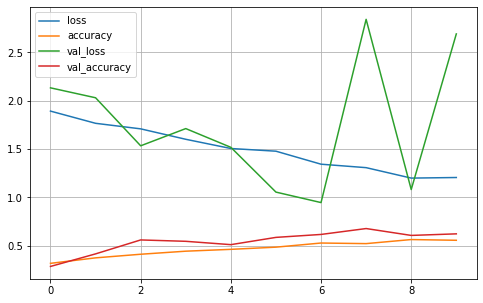

In [11]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [12]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 3s 156ms/step - loss: 0.9456 - accuracy: 0.6159


In [13]:
#print accuracy    
print('Accuracy: %f' % (accuracy*100))

Accuracy: 61.585367


In [14]:
#acuracy and loss
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 61.585 
 loss : 0.946


In [15]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
#pred_labels

In [16]:
pd.Series(pred_labels).value_counts()

glioma_tumor        224
pituitary_tumor     139
meningioma_tumor     79
no_tumor             50
dtype: int64

Text(70.8, 0.5, 'Predicted class')

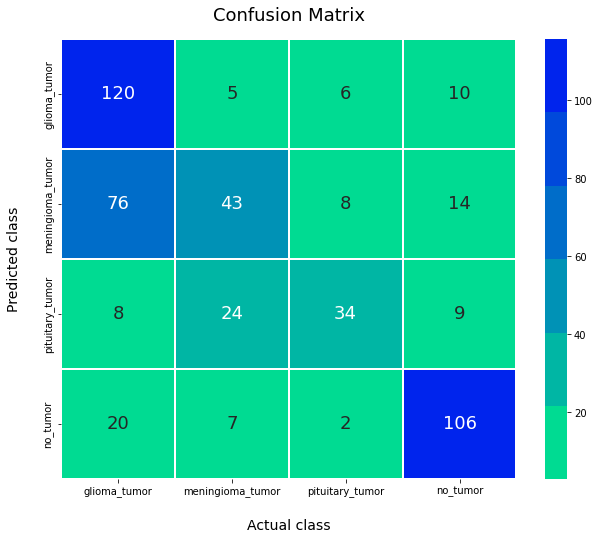

In [17]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

In [18]:
#y_test_labels
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.54      0.85      0.66       141
meningioma_tumor       0.54      0.30      0.39       141
 pituitary_tumor       0.68      0.45      0.54        75
        no_tumor       0.76      0.79      0.77       135

        accuracy                           0.62       492
       macro avg       0.63      0.60      0.59       492
    weighted avg       0.62      0.62      0.60       492

